# Hypothesis Test 3

## Data Collection

In [15]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from scipy import stats


In the cells below, we are creating a connection to our PSQL databased named 'soccer'. This allows us to select data from certain tables in PSQL and turn them into dataframes that we can later join or merge in order to explore our data. 

In [16]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()
query = '''
SELECT *
FROM Country
;'''
cur.execute(query)

In [17]:
countries_data = cur.fetchall()
countries_df = pd.DataFrame(countries_data)
countries_df.columns = [i[0] for i in cur.description]
countries_df.head()

id     name
0      1  Belgium
1   1729  England
2   4769   France
3   7809  Germany
4  10257    Italy

In [18]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()
query = '''
SELECT *
FROM League
;'''
cur.execute(query)
league_data = cur.fetchall()
league_df = pd.DataFrame(league_data)
league_df.columns = [i[0] for i in cur.description]
league_df.head()

id  country_id                    name
0      1           1  Belgium Jupiler League
1   1729        1729  England Premier League
2   4769        4769          France Ligue 1
3   7809        7809   Germany 1. Bundesliga
4  10257       10257           Italy Serie A

In [19]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Match
;'''

cur.execute(query)

match_data = cur.fetchall()
match_df = pd.DataFrame(match_data)
match_df.columns = [i[0] for i in cur.description]

In [20]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Player_Attributes
;'''

cur.execute(query)

player_attrib_data = cur.fetchall()
player_attrib_df = pd.DataFrame(player_attrib_data)
player_attrib_df.columns = [i[0] for i in cur.description]


In [21]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Team
;'''

cur.execute(query)

team_data = cur.fetchall()
team_df = pd.DataFrame(team_data)
team_df.columns = [i[0] for i in cur.description]


In [22]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Team_Attributes
;'''

cur.execute(query)

team_attrib_data = cur.fetchall()
team_attrib_df = pd.DataFrame(team_attrib_data)
team_attrib_df.columns = [i[0] for i in cur.description]


In [23]:
player_df = pd.read_csv('player.csv')


 # HYPOTHESIS TEST 3


- H0 (Null Hypothesis): there is no statistically significant difference in the defensive aggressiveness between the English and French soccer leagues. (mu_defenceaggression_english = mu_defenceaggression_french)
- HA (Alternative Hypothesis): there is no statistically significant difference in the defensive aggressiveness between the English and French soccer leagues. (mu_defenceaggression_english != mu_defenceaggression_french)

- Alpha = 0.05

##### Assumptions:
- Data is collected randomly
- Data is independent
- Data is approximately normally distributed

# Data Formatting

We had to make several merge and joins in order to compare the leagues. 
Below we merged the match data with the league_ids so that we can see which matches were played in each league

In [24]:
match_league_df = match_df.merge(league_df, left_on='league_id', right_on='id')

In [25]:
match_league_df['name'].value_counts()


England Premier League      3040
Spain LIGA BBVA             3040
France Ligue 1              3040
Italy Serie A               3017
Germany 1. Bundesliga       2448
Netherlands Eredivisie      2448
Portugal Liga ZON Sagres    2052
Poland Ekstraklasa          1920
Scotland Premier League     1824
Belgium Jupiler League      1728
Switzerland Super League    1422
Name: name, dtype: int64

Below we have join the team attribute dataframe(which holds team charatericics like defensive aggression and chance creations) with the names of the leagues in the match league dataframe. This gives us a dataframe containing teams, their attributes and the league that they play in. 

In [26]:
team_attrib_by_league=team_attrib_df.join(match_league_df['name'], on='team_api_id', how='left')

By examining the value counts of our dataframe, we can see that they are only two leagues with a decent amount of data. We would have liked to look at other leagues, but we are limited by our dataset.

In [27]:
defense = team_attrib_by_league[['defenceaggression', 'team_api_id', 'name']]
defense['name'].value_counts()

England Premier League      739
France Ligue 1              665
Poland Ekstraklasa           29
Portugal Liga ZON Sagres      8
Belgium Jupiler League        6
Name: name, dtype: int64

In order to extract the rows/matches of the teams in the two leagues we are exploring, we have to create slices of the dataframe that only hold data from each league.

In [28]:
#swiss_d = defense.loc[defense['defenseaggression'], 'name' == 'Switzerland Super League']
english_d = defense[defense['name'].str.contains("England")==True]
french_d = defense[defense['name'].str.contains("France")==True]


Numpy Arrays of Match/Defense Aggressiveness Data

In [29]:
english_array_df = english_d['defenceaggression']
english_array = np.array(english_array_df)
len(english_array)

739

In [30]:
french_array_df = french_d['defenceaggression']
french_array = np.array(french_array_df)
len(french_array)

665

## Two Sample Test Functions

In [31]:
def calc_variance(sample):
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean)**2 for i in sample])

def calc_sample_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var1, var2 = calc_variance(sample1), calc_variance(sample2)
    return (var1 + var2) / ((n_1 + n_2) - 2)

def calc_twosample_tstatistic(expr, ctrl):
    expr_mean, ctrl_mean = np.mean(expr), np.mean(ctrl)
    n_e, n_c = len(expr), len(ctrl)
    samp_var = calc_sample_variance(expr,ctrl)
    t = (expr_mean - ctrl_mean) / np.sqrt(samp_var * ((1/n_e)+(1/n_c)))
    return t


# Power Testing for Sample Sizes

In [ ]:
# Initialize parameters
effect = cohens_d2
alpha = 0.05
power = 0.67
# ratio of 442wins which is 442win sum /442feat  sum
ratio = len(four33_df)/len(four42_df)
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,
                             ratio=ratio, alpha=alpha)
print(f"The minimum sample size: {result}")
print(f"Number of matches where 442 formation is played:{len(four42_df)}")

## England Vs French Defensive Aggressiveness

Vizualing data for understanding

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


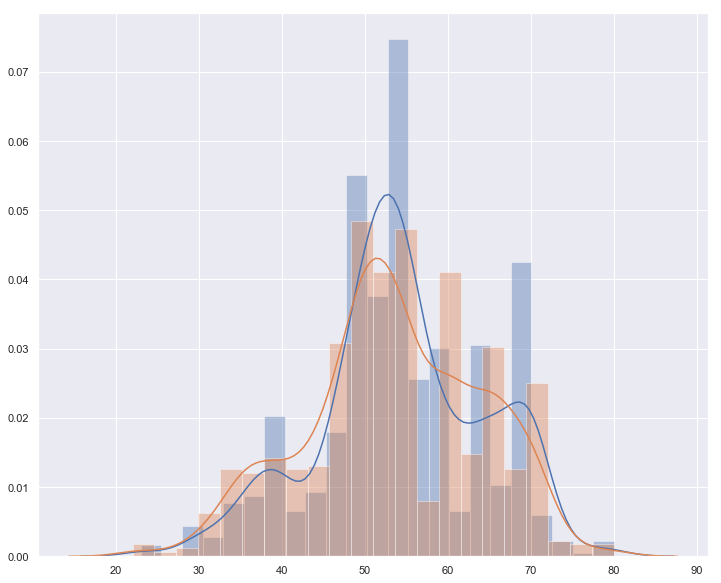

In [57]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(english_array) # Blue distribution
sns.distplot(french_array) # Green distribution

In order to run our test, we have to create samples. Create an empty list and randomly select 50 samples from our data. This allows our test to be as random as possible.

In [33]:
sample_means_english = []
for _ in range(50):
    sample_mean = np.random.choice(english_array,size=50).mean()
    sample_means_english.append(sample_mean)
len(sample_means_english)

sample_means_french = []
for _ in range(50):
    sample_mean = np.random.choice(french_array,size=50).mean()
    sample_means_french.append(sample_mean)
len(sample_means_french)

50

In [34]:
sample_means_english
sample_means_french

[48.14,
 46.88,
 48.64,
 49.54,
 48.74,
 49.42,
 46.52,
 50.3,
 48.56,
 50.04,
 48.86,
 48.12,
 48.98,
 46.6,
 48.62,
 45.66,
 46.7,
 49.64,
 50.14,
 47.72,
 46.24,
 48.44,
 50.34,
 49.92,
 48.1,
 51.58,
 47.88,
 49.2,
 47.98,
 48.48,
 51.66,
 49.26,
 50.04,
 48.2,
 47.4,
 48.18,
 48.88,
 47.98,
 50.3,
 48.02,
 48.96,
 48.48,
 49.76,
 48.2,
 47.34,
 48.16,
 49.1,
 48.98,
 48.82,
 50.64]

In [37]:
t_stat = calc_twosample_tstatistic(sample_means_english, sample_means_french)

t_stat

3.483207855979336

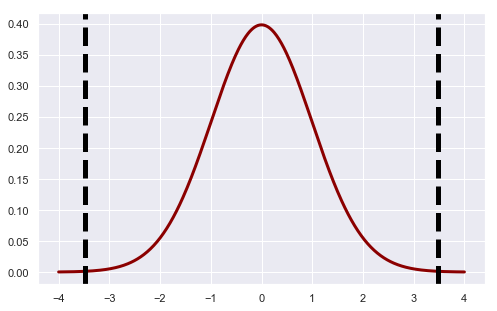

In [38]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(sample_means_english)
n_experimental = len(sample_means_french)
visualize_t(t_stat, n_control, n_experimental)

We use Sklearn here to double check that our math was correct.

In [39]:
stats.ttest_ind(sample_means_english, sample_means_french)

Ttest_indResult(statistic=3.483207855979336, pvalue=0.0007420691379866555)

## Conclusion:
#### We reject the Null Hypothesis (H0) that there is no statistically significant difference of defensive aggressiveness between the English and French soccer leagues

# Hypothesis 4
## English vs France
### Cross Creation

In [44]:
team_attrib_by_league.groupby('name').mean()

id  team_fifa_api_id  team_api_id  \
name                                                                   
Belgium Jupiler League    1115.500000        874.000000  1601.000000   
England Premier League     723.814614      19511.317997  8353.744249   
France Ligue 1             746.327820      10798.747368  9978.723308   
Poland Ekstraklasa         725.965517      71989.103448  2068.275862   
Portugal Liga ZON Sagres   341.750000     111310.375000  4118.125000   

                          buildupplayspeed  buildupplaydribbling  \
name                                                               
Belgium Jupiler League           47.333333             48.000000   
England Premier League           52.637348             48.166008   
France Ligue 1                   52.577444             48.884793   
Poland Ekstraklasa               47.724138             53.250000   
Portugal Liga ZON Sagres         50.500000             43.000000   

                          buildupplaypassing  chancecreationpassing  \
name                                                                  
Belgium Jupiler League             46.166667              55.500000   
England Premier League             48.682003              52.416779   
France Ligue 1                     48.327820              51.935338   
Poland Ekstraklasa                 48.620690              52.517241   
Portugal Liga ZON Sagres           44.375000              46.875000   

                          chancecreationcrossing  chancecreationshooting  \
name                                                                       
Belgium Jupiler League                 60.333333               53.500000   
England Premier League                 53.802436               54.297700   
France Ligue 1                         53.966917               53.502256   
Poland Ekstraklasa                     47.896552               59.000000   
Portugal Liga ZON Sagres               58.500000               58.375000   

                          defencepressure  defenceaggression  defenceteamwidth  
name                                                                            
Belgium Jupiler League          47.166667          47.333333         49.333333  
England Premier League          46.051421          49.671177         52.684709  
France Ligue 1                  45.921805          48.993985         51.672180  
Poland Ekstraklasa              49.620690          45.344828         53.137931  
Portugal Liga ZON Sagres        47.875000          53.125000         58.250000

In [45]:
chance_creation = team_attrib_by_league[['chancecreationshooting', 'team_api_id', 'name']]
chance_creation['name'].value_counts()

England Premier League      739
France Ligue 1              665
Poland Ekstraklasa           29
Portugal Liga ZON Sagres      8
Belgium Jupiler League        6
Name: name, dtype: int64

In [46]:
english_cross = chance_creation[chance_creation['name'].str.contains("England")==True]
french_cross = chance_creation[chance_creation['name'].str.contains("France")==True]

In [47]:
english_cross_array = english_cross['chancecreationshooting']
english_array = np.array(english_cross_array)
len(english_cross_array)

french_cross_array = french_cross['chancecreationshooting']
french_array = np.array(french_cross_array)
len(french_cross_array)

665

In [48]:
sample_means_english_cross = []
for _ in range(50):
    sample_mean = np.random.choice(english_cross_array,size=50).mean()
    sample_means_english_cross.append(sample_mean)
len(sample_means_english_cross)

sample_means_french_cross= []
for _ in range(50):
    sample_mean = np.random.choice(french_cross_array,size=50).mean()
    sample_means_french_cross.append(sample_mean)
len(sample_means_french_cross)

50

In [53]:
t_stat = calc_twosample_tstatistic(sample_means_english_cross, sample_means_french_cross)

t_stat

2.4361528692457046

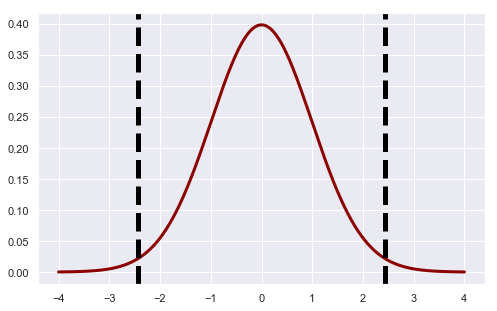

In [54]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(sample_means_english_cross)
n_experimental = len(sample_means_french_cross)
visualize_t(t_stat, n_control, n_experimental)

Again, using Sklearn to confirm that our math and functions are the same

In [56]:
sk_test = stats.ttest_ind(sample_means_english_cross, sample_means_french_cross)
sk_test

Ttest_indResult(statistic=2.4361528692457046, pvalue=0.01664999360038073)

## Conclusion:
#### We reject the Null Hypothesis (H0) that there is no statistically significant difference of defensive aggressiveness between the English and French soccer leagues